# 📡 ISCX VPN/Non-VPN 트래픽 유형 분류 (다중 클래스)
본 노트북에서는 ISCX VPN/Non-VPN 데이터셋으로부터 `.pcap` 파일을 처리하여, 트래픽 유형(chat, email, audio 등)을 분류하는 머신러닝 모델을 구성합니다.

## 📁 1. 환경 설정 및 필요 라이브러리 불러오기

In [1]:

# 파일 처리, 머신러닝, 시각화를 위한 라이브러리들을 불러옵니다.
import os
import pandas as pd
import subprocess
import glob
from tqdm import tqdm

# sklearn은 머신러닝 모델 학습과 평가에 사용됩니다.
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns


## 📂 2. 데이터셋 경로 및 출력 경로 설정

In [3]:

# Non-VPN 및 VPN 데이터셋이 저장된 디렉토리 경로를 지정합니다.
NONVPN_DIR = "dataset/NonVPN-PCAPs-01"
VPN_DIR = "dataset/VPN-PCAPS-01"

# 추출된 CSV 파일들을 저장할 출력 디렉토리입니다.
OUTPUT_DIR = "dataset/output_csvs"
os.makedirs(OUTPUT_DIR, exist_ok=True)  # 디렉토리가 없으면 생성


## 🏷️ 3. 트래픽 유형(label) 분류 함수

In [5]:

# 파일 이름에 포함된 키워드를 바탕으로 트래픽 유형을 분류합니다.
def get_traffic_type(filename):
    fname = filename.lower()
    if 'chat' in fname:
        return 'chat'
    elif 'email' in fname:
        return 'email'
    elif 'audio' in fname:
        return 'audio'
    elif 'video' in fname:
        return 'video'
    elif 'ftp' in fname or 'file' in fname or 'bittorrent' in fname:
        return 'file_transfer'
    else:
        return 'other'  # 위의 조건에 포함되지 않으면 기타로 분류


## 🧪 4. PCAP 파일 → CSV 피처 추출 함수

In [7]:
import pandas as pd
import numpy as np
import subprocess

# 딥러닝 친화 파생 피처를 확장한 버전 (함수 시그니처/호출부 동일)
def extract_and_save_csv(pcap_path, output_csv_path, label):
    tshark_fields = [
        "-T", "fields",
        "-e", "frame.time_relative",  # 패킷의 상대 시간
        "-e", "frame.len",            # 패킷 길이
        "-e", "ip.src",               # 출발지 IP
        "-e", "ip.dst",               # 목적지 IP
        "-E", "separator=,"
    ]
    tshark_path = r"C:\Program Files\Wireshark\tshark.exe"  # 실제 설치 경로 확인
    cmd = [tshark_path, "-r", pcap_path] + tshark_fields

    # ------------------------
    # Helper: 안전한 엔트로피
    # ------------------------
    def _safe_entropy(vals, bins):
        """패킷 길이 분포 엔트로피 (히스토그램 기반)"""
        if len(vals) == 0:
            return 0.0
        counts, _ = np.histogram(vals, bins=bins)
        total = counts.sum()
        if total == 0:
            return 0.0
        p = counts / total
        p = p[p > 0]
        return float(-(p * np.log(p)).sum())

    try:
        # tshark 실행
        output = subprocess.check_output(cmd, stderr=subprocess.DEVNULL).decode(errors="ignore")
        lines = [ln for ln in output.strip().split("\n") if ln.strip()]
        packets = [line.split(",") for line in lines if len(line.split(",")) == 4]
        if not packets:
            print(f"[ℹ️] tshark 출력이 비어 있음: {pcap_path}")
            return

        # 기본 프레임 데이터
        df = pd.DataFrame(packets, columns=["time", "length", "src", "dst"])
        df["time"] = pd.to_numeric(df["time"], errors='coerce')
        df["length"] = pd.to_numeric(df["length"], errors='coerce')
        df = df.dropna(subset=["time", "length"])
        if df.empty:
            print(f"[ℹ️] 유효 행 없음(시간/길이 무효): {pcap_path}")
            return

        # 흐름 키(방향성 없이 src-dst 조합)
        df["flow"] = (df["src"].astype(str) + "-" + df["dst"].astype(str))

        # IAT
        df = df.sort_values(["flow", "time"]).reset_index(drop=True)
        df["iat"] = df.groupby("flow")["time"].diff()  # 첫 패킷 NaN

        # ------------------------
        # 1) 기본 통계 + 분위수/왜도/첨도
        # ------------------------
        def q25(x): 
            x = x.dropna()
            return float(np.quantile(x, 0.25)) if len(x) else 0.0
        def q75(x): 
            x = x.dropna()
            return float(np.quantile(x, 0.75)) if len(x) else 0.0
        def safe_skew(x):
            x = x.dropna()
            return float(pd.Series(x).skew()) if len(x) > 2 else 0.0
        def safe_kurt(x):
            x = x.dropna()
            return float(pd.Series(x).kurt()) if len(x) > 3 else 0.0

        base = df.groupby("flow").agg(
            time_min=("time", "min"),
            time_max=("time", "max"),
            packet_count=("length", "count"),
            total_bytes=("length", "sum"),
            avg_pkt_size=("length", "mean"),
            std_pkt_size=("length", "std"),
            min_pkt_size=("length", "min"),
            max_pkt_size=("length", "max"),
            median_pkt_size=("length", "median"),
            p25_pkt_size=("length", q25),
            p75_pkt_size=("length", q75),
            skew_pkt_size=("length", safe_skew),
            kurt_pkt_size=("length", safe_kurt),

            avg_iat=("iat", "mean"),
            std_iat=("iat", "std"),
            min_iat=("iat", "min"),
            max_iat=("iat", "max"),
            median_iat=("iat", "median"),
            p25_iat=("iat", q25),
            p75_iat=("iat", q75),
            skew_iat=("iat", safe_skew),
            kurt_iat=("iat", safe_kurt),
        ).reset_index()

        if base.empty:
            print(f"[ℹ️] 집계 결과 없음: {pcap_path}")
            return

        # ------------------------
        # 2) 분포 엔트로피/히스토 비율
        # ------------------------
        size_bins = np.array([0, 128, 256, 512, 1024, 1514, 9000, 1e9], dtype=float)
        iat_bins  = np.array([0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 1e9], dtype=float)

        # per-flow histogram features
        ent_rows = []
        for k, g in df.groupby("flow"):
            d = {"flow": k}
            # size hist + 비율
            size_counts, _ = np.histogram(g["length"].values, bins=size_bins)
            size_total = size_counts.sum() if size_counts.sum() > 0 else 1
            for i in range(len(size_counts)):
                d[f"size_bin_{i}"] = int(size_counts[i])
                d[f"size_pr_{i}"]  = float(size_counts[i] / size_total)
            d["size_entropy"] = _safe_entropy(g["length"].values, size_bins)

            # iat hist + 비율 (NaN 제거)
            iats = g["iat"].dropna().values
            iat_counts, _ = np.histogram(iats, bins=iat_bins)
            iat_total = iat_counts.sum() if iat_counts.sum() > 0 else 1
            for i in range(len(iat_counts)):
                d[f"iat_bin_{i}"] = int(iat_counts[i])
                d[f"iat_pr_{i}"]  = float(iat_counts[i] / iat_total)
            d["iat_entropy"] = _safe_entropy(iats, iat_bins)
            ent_rows.append(d)
        ent_df = pd.DataFrame(ent_rows)

        # ------------------------
        # 3) 파생 피처(비율/변동/범위/버스트/로그/루트)
        # ------------------------
        feats = base.merge(ent_df, on="flow", how="left").fillna(0.0)

        # 기간/레이트
        eps = 1e-6
        feats["duration"]    = (feats["time_max"] - feats["time_min"]).clip(lower=0)
        feats["packet_rate"] = feats["packet_count"] / (feats["duration"] + eps)
        feats["byte_rate"]   = feats["total_bytes"]  / (feats["duration"] + eps)
        feats["byte_per_packet"] = feats["total_bytes"] / (feats["packet_count"] + eps)

        # 변동계수(CV)
        feats["cv_pkt_size"] = feats["std_pkt_size"] / (feats["avg_pkt_size"] + eps)
        feats["cv_iat"]      = feats["std_iat"]      / (feats["avg_iat"] + eps)

        # 범위
        feats["range_pkt_size"] = (feats["max_pkt_size"] - feats["min_pkt_size"]).clip(lower=0)
        feats["range_iat"]      = (feats["max_iat"] - feats["min_iat"]).clip(lower=0)

        # IQR
        feats["iqr_pkt_size"] = (feats["p75_pkt_size"] - feats["p25_pkt_size"]).clip(lower=0)
        feats["iqr_iat"]      = (feats["p75_iat"]      - feats["p25_iat"]).clip(lower=0)

        # 비율/정규화
        feats["pkt_size_norm"] = feats["avg_pkt_size"] / (feats["max_pkt_size"] + eps)
        feats["iat_norm"]      = feats["avg_iat"]      / (feats["max_iat"] + eps)

        # 버스트 지표
        feats["burst_iat"] = feats["max_iat"]      / (feats["avg_iat"] + eps)
        feats["burst_pkt"] = feats["max_pkt_size"] / (feats["avg_pkt_size"] + eps)

        # 조합 피처
        feats["size_per_iat"] = feats["avg_pkt_size"] / (feats["avg_iat"] + eps)
        feats["bytes_per_iqr_iat"] = feats["total_bytes"] / (feats["iqr_iat"] + eps)

        # 로그/루트 변환 (스케일 안정화)
        for col in [
            "total_bytes","duration","packet_count",
            "packet_rate","byte_rate","avg_pkt_size","avg_iat",
            "range_pkt_size","range_iat","iqr_pkt_size","iqr_iat"
        ]:
            feats[f"log_{col}"]  = np.log1p(np.maximum(0, feats[col]))
            feats[f"sqrt_{col}"] = np.sqrt(np.maximum(0, feats[col]) + 1.0)

        # 정리: 원시 시간 컬럼 제거, 레이블 부여
        feats = feats.drop(columns=["time_min", "time_max"], errors="ignore")
        feats["label"] = label

        # NaN/Inf 정리
        feats = feats.replace([np.inf, -np.inf], 0.0).fillna(0.0)

        if feats.empty:
            print(f"[ℹ️] 생성된 피처가 없습니다: {pcap_path}")
            return

        feats.to_csv(output_csv_path, index=False)

    except Exception as e:
        print(f"[⚠️] Error processing {pcap_path}: {e}")


## 🔁 5. 전체 PCAP 파일 처리 및 CSV 저장

In [9]:
# 전체 pcap 파일들을 순회하며 피처를 추출하고 CSV 파일로 저장합니다.
def batch_convert_pcaps():
    for folder in [NONVPN_DIR, VPN_DIR]:
        pcap_files = glob.glob(os.path.join(folder, "*.pcap")) + glob.glob(os.path.join(folder, "*.pcapng"))
        for pcap_file in tqdm(pcap_files, desc=f"Processing {folder}"):
            filename = os.path.basename(pcap_file)
            label = get_traffic_type(filename)
            output_csv_path = os.path.join(OUTPUT_DIR, filename.replace(".pcapng", ".csv").replace(".pcap", ".csv"))
            extract_and_save_csv(pcap_file, output_csv_path, label)

# 변환 실행
batch_convert_pcaps()


Processing dataset/VPN-PCAPS-01: 100%|█████████████████████████████████████████████████| 14/14 [01:58<00:00,  8.44s/it]


## 📊 6. CSV 병합 및 데이터 섞기

In [11]:

# 개별 CSV 파일들을 하나로 합치고, 데이터를 셔플하여 저장합니다.
INPUT_DIR = OUTPUT_DIR
OUTPUT_CSV = "output_multiple.csv"

def merge_all_csvs():
    all_csvs = glob.glob(os.path.join(INPUT_DIR, "*.csv"))
    dfs = []
    for csv_file in all_csvs:
        try:
            df = pd.read_csv(csv_file)
            dfs.append(df)
        except Exception as e:
            print(f"[⚠️] Error reading {csv_file}: {e}")

    if dfs:
        final_df = pd.concat(dfs, ignore_index=True)
        final_df = shuffle(final_df, random_state=42)  # 무작위 섞기
        final_df.to_csv(OUTPUT_CSV, index=False)
        print(f"✅ Merged CSV saved to {OUTPUT_CSV} (Total: {len(final_df)} rows)")
    else:
        print("❌ No CSV files found or all failed.")

merge_all_csvs()


✅ Merged CSV saved to output_multiple.csv (Total: 2773 rows)


## 🧠 7. 머신러닝 모델 학습 및 평가

               precision    recall  f1-score   support

        audio       0.89      0.92      0.91       190
         chat       0.82      0.80      0.81        70
        email       0.89      0.90      0.89        97
file_transfer       0.81      0.85      0.83        20
        video       0.62      0.48      0.54        27

     accuracy                           0.86       404
    macro avg       0.81      0.79      0.80       404
 weighted avg       0.86      0.86      0.86       404



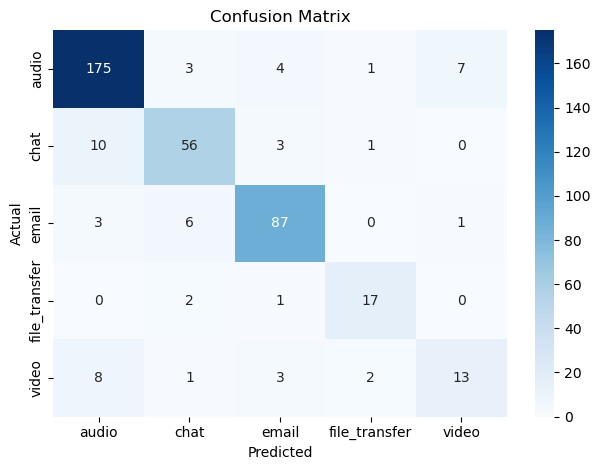

In [15]:
from sklearn.preprocessing import StandardScaler

# 학습용 데이터를 불러오고, 랜덤포레스트 모델을 학습한 후 평가합니다.
df = pd.read_csv("output_multiple.csv").dropna()
X = df.drop(columns=["flow", "label"])  # 피처만 사용
y = df["label"]

# 1) 짧은 플로우 컷
if "packet_count" in df.columns:
    df = df[df["packet_count"] >= 3].reset_index(drop=True)

# 2) 라벨 인코딩 (컷 이후)
le = LabelEncoder()
df["label_enc"] = le.fit_transform(df["label"])

# 3) 피처 선택 (숫자형만)
X = df.drop(columns=["label","label_enc","flow"], errors="ignore").select_dtypes(include=[np.number]).copy()
y = df["label_enc"]

# 4) 스케일링 (랜덤포레스트에도 적용)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)

# 5) 동일 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 모델 정의 및 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 평가 지표 출력
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix 시각화
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## 🔥 8. 딥러닝 모델 (ResMLP + FT-Transforemr + Plain 앙상블) 학습 및 평가

[ResMLP] Epoch 1/250: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.34it/s]


ResMLP | epoch 1 | loss 1.4008 | acc 0.4567


[ResMLP] Epoch 20/250: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.39it/s]


ResMLP | epoch 20 | loss 0.4190 | acc 0.8465


[ResMLP] Epoch 40/250: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


ResMLP | epoch 40 | loss 0.2996 | acc 0.9010


[ResMLP] Epoch 60/250: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.44it/s]


ResMLP | epoch 60 | loss 0.2341 | acc 0.9431


[ResMLP] Epoch 80/250: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


ResMLP | epoch 80 | loss 0.1923 | acc 0.9548


[ResMLP] Epoch 100/250: 100%|████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.43it/s]


ResMLP | epoch 100 | loss 0.1732 | acc 0.9629


[ResMLP] Epoch 120/250: 100%|████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.44it/s]


ResMLP | epoch 120 | loss 0.1639 | acc 0.9653


[ResMLP] Epoch 140/250: 100%|████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.41it/s]


ResMLP | epoch 140 | loss 0.1535 | acc 0.9746


[ResMLP] Epoch 160/250: 100%|████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


ResMLP | epoch 160 | loss 0.1440 | acc 0.9765


[ResMLP] Epoch 180/250: 100%|████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


ResMLP | epoch 180 | loss 0.1424 | acc 0.9783


[ResMLP] Epoch 200/250: 100%|████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.43it/s]


ResMLP | epoch 200 | loss 0.1301 | acc 0.9845


[ResMLP] Epoch 220/250: 100%|████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


ResMLP | epoch 220 | loss 0.1319 | acc 0.9827


[ResMLP] Epoch 240/250: 100%|████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.41it/s]


ResMLP | epoch 240 | loss 0.1284 | acc 0.9845


[FTT] Epoch 1/250: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.34it/s]


FTT | epoch 1 | loss 1.4710 | acc 0.4288


[FTT] Epoch 20/250: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.09it/s]


FTT | epoch 20 | loss 0.4184 | acc 0.8335


[FTT] Epoch 40/250: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.37it/s]


FTT | epoch 40 | loss 0.2660 | acc 0.9090


[FTT] Epoch 60/250: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.01it/s]


FTT | epoch 60 | loss 0.2180 | acc 0.9412


[FTT] Epoch 80/250: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.12it/s]


FTT | epoch 80 | loss 0.1839 | acc 0.9554


[FTT] Epoch 100/250: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.85it/s]


FTT | epoch 100 | loss 0.1620 | acc 0.9709


[FTT] Epoch 120/250: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.41it/s]


FTT | epoch 120 | loss 0.1555 | acc 0.9728


[FTT] Epoch 140/250: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.96it/s]


FTT | epoch 140 | loss 0.1433 | acc 0.9777


[FTT] Epoch 160/250: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.37it/s]


FTT | epoch 160 | loss 0.1370 | acc 0.9796


[FTT] Epoch 180/250: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.34it/s]


FTT | epoch 180 | loss 0.1310 | acc 0.9839


[FTT] Epoch 200/250: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.45it/s]


FTT | epoch 200 | loss 0.1266 | acc 0.9851


[FTT] Epoch 220/250: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.04it/s]


FTT | epoch 220 | loss 0.1236 | acc 0.9882


[FTT] Epoch 240/250: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.10it/s]


FTT | epoch 240 | loss 0.1239 | acc 0.9876


[PlainMLP] Epoch 1/250: 100%|████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.30it/s]


PlainMLP | epoch 1 | loss 1.5880 | acc 0.4629


[PlainMLP] Epoch 20/250: 100%|███████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.52it/s]


PlainMLP | epoch 20 | loss 0.6702 | acc 0.7345


[PlainMLP] Epoch 40/250: 100%|███████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.08it/s]


PlainMLP | epoch 40 | loss 0.5219 | acc 0.7927


[PlainMLP] Epoch 60/250: 100%|███████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.74it/s]


PlainMLP | epoch 60 | loss 0.4595 | acc 0.8038


[PlainMLP] Epoch 80/250: 100%|███████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 13.53it/s]


PlainMLP | epoch 80 | loss 0.4048 | acc 0.8478


[PlainMLP] Epoch 100/250: 100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.55it/s]


PlainMLP | epoch 100 | loss 0.3538 | acc 0.8756


[PlainMLP] Epoch 120/250: 100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.81it/s]


PlainMLP | epoch 120 | loss 0.3078 | acc 0.8892


[PlainMLP] Epoch 140/250: 100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.79it/s]


PlainMLP | epoch 140 | loss 0.2852 | acc 0.9084


[PlainMLP] Epoch 160/250: 100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.04it/s]


PlainMLP | epoch 160 | loss 0.2842 | acc 0.9041


[PlainMLP] Epoch 180/250: 100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.12it/s]


PlainMLP | epoch 180 | loss 0.2844 | acc 0.9084


[PlainMLP] Epoch 200/250: 100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.17it/s]


PlainMLP | epoch 200 | loss 0.2711 | acc 0.9177


[PlainMLP] Epoch 220/250: 100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.14it/s]


PlainMLP | epoch 220 | loss 0.2736 | acc 0.9233


[PlainMLP] Epoch 240/250: 100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.87it/s]


PlainMLP | epoch 240 | loss 0.2744 | acc 0.9177


[PlainMLP] Epoch 250/250: 100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.18it/s]



[ResMLP  ] Acc: 0.7920792079207921 | Macro-F1: 0.7225553729545484
[FTT     ] Acc: 0.806930693069307 | Macro-F1: 0.7390434062050645
[PlainMLP] Acc: 0.7673267326732673 | Macro-F1: 0.7072769625635108

[DL-Only Soft-Vote] Acc: 0.8118811881188119 | Macro-F1: 0.7489615579442095

Classification report (DL-only ensemble):
                precision    recall  f1-score   support

        audio     0.8717    0.8579    0.8647       190
         chat     0.7500    0.7286    0.7391        70
        email     0.8384    0.8557    0.8469        97
file_transfer     0.6800    0.8500    0.7556        20
        video     0.5600    0.5185    0.5385        27

     accuracy                         0.8119       404
    macro avg     0.7400    0.7621    0.7490       404
 weighted avg     0.8123    0.8119    0.8115       404



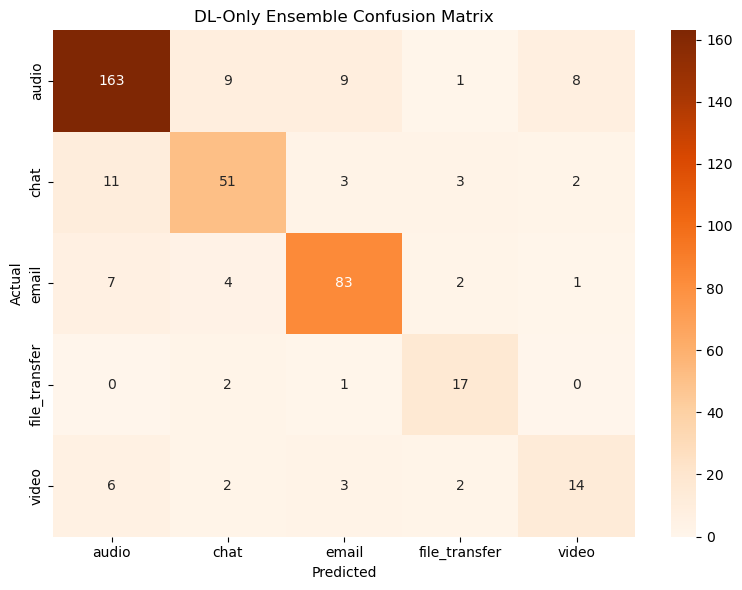

In [17]:
# -*- coding: utf-8 -*-
# DL-only 3-Model Ensemble: ResMLP + FT-Transformer + PlainMLP (train/test only)

import numpy as np, pandas as pd, torch, torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

# ===================== Config =====================
CSV_PATH = "output_multiple.csv"
TEST_SIZE = 0.2
SEED = 42
BATCH_TRAIN = 256
BATCH_TEST  = 512
EPOCHS = 250
LR = 5e-4
WD = 1e-4
CLIP_NORM = 1.0
LABEL_SMOOTH = 0.01

# soft-vote weights: ens = wA*ResMLP + wB*FTT + wC*PlainMLP  (wA+wB+wC=1 권장)
W_A, W_B, W_C = 0.45, 0.45, 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(SEED); torch.manual_seed(SEED)

# ===================== Data =====================
df = pd.read_csv(CSV_PATH)

# 1) (전처리) 아주 짧은 플로우 컷
if "packet_count" in df.columns:
    df = df[df["packet_count"] >= 3].reset_index(drop=True)

# 2) (라벨) 컷 이후에 인코딩해야 현재 남은 클래스만 반영됨
le = LabelEncoder()
df["label_enc"] = le.fit_transform(df["label"])

# 3) (특징/타깃 분리)
X = df.drop(columns=["label","label_enc","flow"], 
            errors="ignore").select_dtypes(include=[np.number]).copy()
y = df["label_enc"].values

# 먼저 split
X_train, X_test, y_train, y_test = train_test_split(
    X.values if hasattr(X, "values") else X,
    y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)

# 그 다음 train으로만 fit
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test ).astype(np.float32)

# NaN/Inf 처리
X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e6, neginf=-1e6)
X_test  = np.nan_to_num(X_test,  nan=0.0, posinf=1e6, neginf=-1e6)


class TabDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(TabDS(X_train,y_train), batch_size=BATCH_TRAIN, shuffle=True)
test_loader  = DataLoader(TabDS(X_test, y_test), batch_size=BATCH_TEST, shuffle=False)

num_features = X_train.shape[1]
num_classes  = len(le.classes_)

# class weights
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_t = torch.tensor(cw, dtype=torch.float32).to(device)

# ===================== Models =====================
class ResBlock(nn.Module):
    def __init__(self, d, hidden, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm1d(d),
            nn.Linear(d, hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden, d),
        )
    def forward(self, x): return x + self.net(x)

class ResMLP(nn.Module):
    def __init__(self, in_dim, num_classes, width=1024, depth=6, p=0.2):
        super().__init__()
        self.inp = nn.Sequential(nn.LayerNorm(in_dim), nn.Linear(in_dim, width))
        self.blocks = nn.ModuleList([ResBlock(width, width*2, p) for _ in range(depth)])
        self.head = nn.Sequential(nn.BatchNorm1d(width), nn.GELU(), nn.Dropout(p), nn.Linear(width, num_classes))
    def forward(self, x):
        x = self.inp(x)
        for b in self.blocks: x = b(x)
        return self.head(x)

class FTTransformerStable(nn.Module):
    def __init__(self, num_features, num_classes, d_model=384, num_layers=5, dropout=0.2):
        super().__init__()
        self.embedding = nn.Sequential(nn.LayerNorm(num_features), nn.Linear(num_features, d_model))
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, d_model*2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_model*2, d_model),
            ) for _ in range(num_layers)
        ])
        self.fc = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))
    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = x + layer(x)
        return self.fc(x)

class PlainMLP(nn.Module):
    def __init__(self, in_dim, num_classes, width=512, depth=3, p=0.2):
        super().__init__()
        layers = [nn.LayerNorm(in_dim), nn.Linear(in_dim, width), nn.GELU(), nn.Dropout(p)]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), nn.GELU(), nn.Dropout(p)]
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(width, num_classes)
    def forward(self, x): return self.head(self.backbone(x))

resmlp = ResMLP(num_features, num_classes).to(device)
ftt    = FTTransformerStable(num_features, num_classes).to(device)
pmlp   = PlainMLP(num_features, num_classes, width=512, depth=3, p=0.2).to(device)

def make_trainer(model):
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    crit = nn.CrossEntropyLoss(weight=cw_t, label_smoothing=LABEL_SMOOTH)
    return opt, sch, crit

opt_A, sch_A, crit_A = make_trainer(resmlp)
opt_B, sch_B, crit_B = make_trainer(ftt)
opt_C, sch_C, crit_C = make_trainer(pmlp)

# ===================== Train loops =====================
def train_model(model, optimizer, scheduler, criterion, name="model"):
    for epoch in range(EPOCHS):
        model.train()
        tot, correct, total = 0.0, 0, 0
        for xb, yb in tqdm(train_loader, desc=f"[{name}] Epoch {epoch+1}/{EPOCHS}"):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            optimizer.step()
            tot += loss.item() * xb.size(0)
            pred = logits.argmax(1)
            correct += (pred==yb).sum().item(); total += yb.size(0)
        scheduler.step()
        if (epoch+1) % 20 == 0 or epoch==0:
            print(f"{name} | epoch {epoch+1} | loss {tot/total:.4f} | acc {correct/total:.4f}")

train_model(resmlp, opt_A, sch_A, crit_A, name="ResMLP")
train_model(ftt,    opt_B, sch_B, crit_B, name="FTT")
train_model(pmlp,   opt_C, sch_C, crit_C, name="PlainMLP")

# ===================== Evaluate =====================
def predict_proba(model):
    model.eval()
    probs, ys = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            p = torch.softmax(model(xb), dim=1).cpu().numpy()
            probs.append(p); ys.extend(yb.numpy())
    return np.vstack(probs), np.array(ys)

probs_A, y_true = predict_proba(resmlp)
probs_B, _      = predict_proba(ftt)
probs_C, _      = predict_proba(pmlp)

# 개별 성능
pred_A = probs_A.argmax(1)
pred_B = probs_B.argmax(1)
pred_C = probs_C.argmax(1)
print("\n[ResMLP  ] Acc:", accuracy_score(y_true, pred_A), "| Macro-F1:", f1_score(y_true, pred_A, average="macro"))
print("[FTT     ] Acc:", accuracy_score(y_true, pred_B), "| Macro-F1:", f1_score(y_true, pred_B, average="macro"))
print("[PlainMLP] Acc:", accuracy_score(y_true, pred_C), "| Macro-F1:", f1_score(y_true, pred_C, average="macro"))

# DL-only soft-vote
ens_probs = W_A*probs_A + W_B*probs_B + W_C*probs_C
ens_pred  = ens_probs.argmax(1)

print("\n[DL-Only Soft-Vote] Acc:", accuracy_score(y_true, ens_pred),
      "| Macro-F1:", f1_score(y_true, ens_pred, average="macro"))
print("\nClassification report (DL-only ensemble):\n",
      classification_report(y_true, ens_pred, target_names=list(le.classes_), digits=4))

# ===================== Confusion Matrix 시각화 =====================
cm = confusion_matrix(y_true, ens_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap="Oranges")
plt.title("DL-Only Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## 🌲 9. 랜덤포레스트 피처 중요도 분석

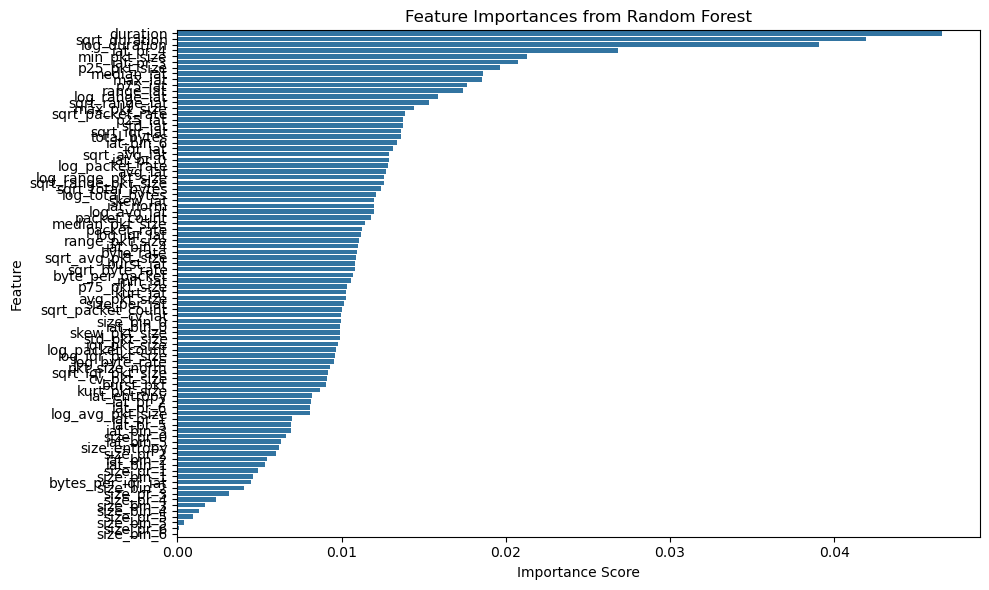

In [19]:
# 학습된 랜덤포레스트 모델을 통해 각 피처의 중요도를 시각화합니다.

# 피처 이름 목록
feature_names = X.columns

# 중요도 추출
importances = clf.feature_importances_

# 중요도를 기준으로 정렬
indices = importances.argsort()[::-1]

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


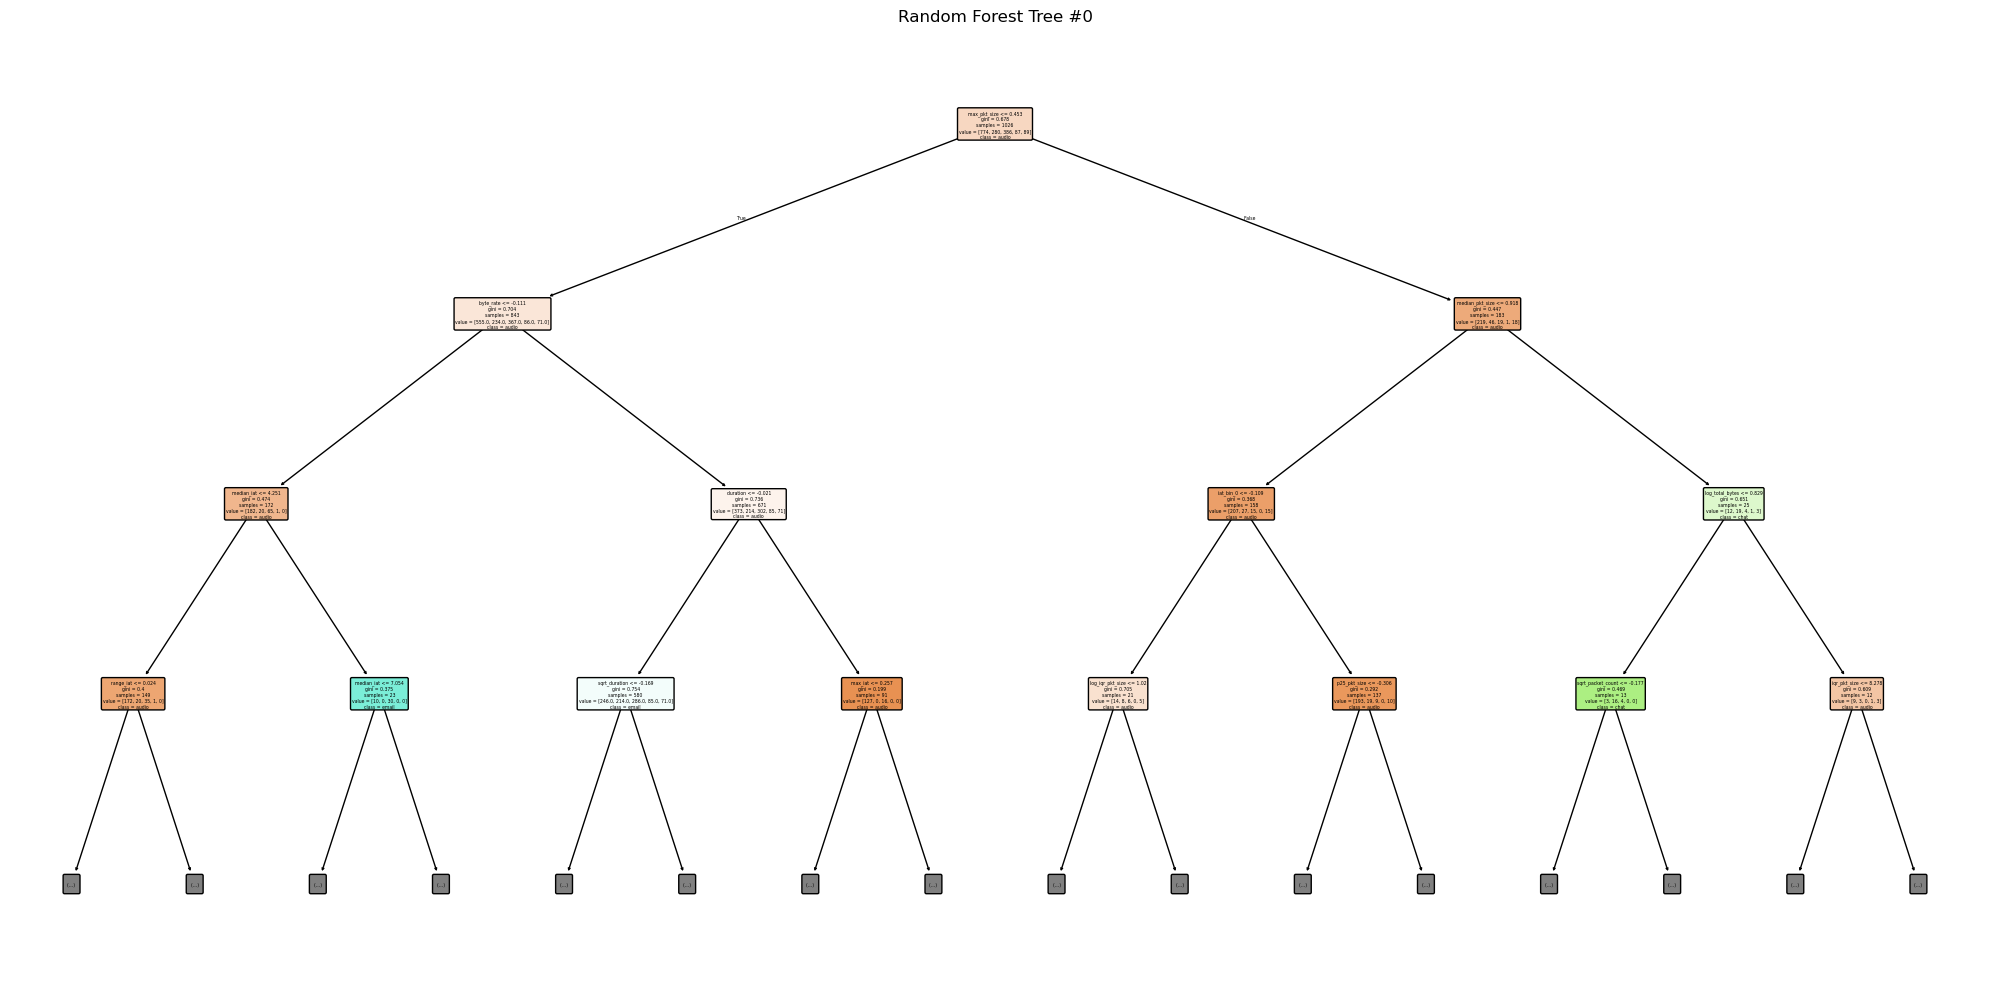

In [21]:
# 랜덤포레스트 내부의 일부 트리를 시각화합니다.
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 몇 개의 트리를 시각화할지 설정
n_trees_to_plot = 1

plt.figure(figsize=(20, 10))
for i in range(n_trees_to_plot):
    plt.clf()
    estimator = clf.estimators_[i]
    plot_tree(estimator,
              feature_names=X.columns,
              class_names=le.classes_,
              filled=True,
              rounded=True,
              max_depth=3)  # 깊이를 제한하여 보기 좋게
    plt.title(f"Random Forest Tree #{i}")
    plt.tight_layout()
    plt.show()